# Fase 3: HSI Calculation

Notebook ini untuk menghitung Habitat Suitability Index (HSI) dari data yang sudah diproses.

## Langkah-langkah:
1. Load processed data
2. Define Suitability Index Functions (HSI_CHL, HSI_SST, HSI_SO)
3. Calculate HSI per grid point per hari
4. Calculate HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)
5. Handle edge cases (missing values, zero values)
6. Save HSI results

## 1. Import Libraries & Load Processed Data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [9]:
# Load processed data
PROCESSED_DATA_FILE = '../data/processed/processed_data.npz'

if not os.path.exists(PROCESSED_DATA_FILE):
    # Try sample file
    PROCESSED_DATA_FILE = '../data/processed/processed_data_sample.npz'
    print(f"⚠️  Using sample data file: {PROCESSED_DATA_FILE}")

if not os.path.exists(PROCESSED_DATA_FILE):
    raise FileNotFoundError(f"Processed data file not found! Please run preprocessing notebook first.")

data = np.load(PROCESSED_DATA_FILE)

processed_chl = data['chl']
processed_sst = data['sst']
processed_salinity = data['salinity']
lat_grid = data['lat_grid']
lon_grid = data['lon_grid']

print(f"✅ Data loaded successfully!")
print(f"\nData shapes:")
print(f"  CHL: {processed_chl.shape}")
print(f"  SST: {processed_sst.shape}")
print(f"  Salinity: {processed_salinity.shape}")
print(f"  Grid: {len(lat_grid)} x {len(lon_grid)}")
print(f"  Time steps: {processed_chl.shape[0]}")

✅ Data loaded successfully!

Data shapes:
  CHL: (1461, 28, 29)
  SST: (1461, 28, 29)
  Salinity: (1461, 28, 29)
  Grid: 28 x 29
  Time steps: 1461


## 2. Define Suitability Index Functions (Vectorized - Fixed)

In [10]:
# Vectorized versions untuk array operations (FIXED VERSION)
def calculate_HSI_CHL_vectorized(chl_array):
    """Calculate HSI for Chlorophyll-a (vectorized)"""
    hsi = np.zeros_like(chl_array)
    
    optimal = 1.0
    tolerance = 0.5
    
    # Valid range mask
    valid_mask = (~np.isnan(chl_array)) & (chl_array >= 0.1) & (chl_array <= 3.0)
    
    if np.any(valid_mask):
        # Flatten untuk perhitungan
        chl_flat = chl_array.flatten()
        valid_flat = valid_mask.flatten()
        hsi_flat = hsi.flatten()
        
        # Calculate distance untuk valid values
        chl_valid = chl_flat[valid_flat]
        distance = np.abs(chl_valid - optimal)
        
        # Optimal range
        optimal_mask = distance <= tolerance
        hsi_flat[valid_flat] = np.where(
            optimal_mask,
            1.0 - (distance / tolerance) * 0.3,
            0.7 - (distance - tolerance) / 2.0
        )
        
        # Clip to [0, 1]
        hsi_flat[valid_flat] = np.clip(hsi_flat[valid_flat], 0.0, 1.0)
        
        # Reshape back
        hsi = hsi_flat.reshape(chl_array.shape)
    
    return hsi

def calculate_HSI_SST_vectorized(sst_array):
    """Calculate HSI for Sea Surface Temperature (vectorized)"""
    hsi = np.zeros_like(sst_array)
    
    optimal_min = 27.0
    optimal_max = 29.0
    min_acceptable = 25.0
    max_acceptable = 31.0
    
    # Valid range mask
    valid_mask = (~np.isnan(sst_array)) & (sst_array >= min_acceptable) & (sst_array <= max_acceptable)
    
    if np.any(valid_mask):
        # Flatten untuk perhitungan
        sst_flat = sst_array.flatten()
        valid_flat = valid_mask.flatten()
        hsi_flat = hsi.flatten()
        
        sst_valid = sst_flat[valid_flat]
        
        # Optimal range
        optimal_mask = (sst_valid >= optimal_min) & (sst_valid <= optimal_max)
        below_mask = sst_valid < optimal_min
        above_mask = sst_valid > optimal_max
        
        # Calculate HSI
        hsi_flat[valid_flat] = np.where(
            optimal_mask, 1.0,
            np.where(
                below_mask,
                (sst_valid - min_acceptable) / (optimal_min - min_acceptable),
                (max_acceptable - sst_valid) / (max_acceptable - optimal_max)
            )
        )
        
        # Clip to [0, 1]
        hsi_flat[valid_flat] = np.clip(hsi_flat[valid_flat], 0.0, 1.0)
        
        # Reshape back
        hsi = hsi_flat.reshape(sst_array.shape)
    
    return hsi

def calculate_HSI_SO_vectorized(salinity_array):
    """Calculate HSI for Salinity (vectorized)"""
    hsi = np.zeros_like(salinity_array)
    
    optimal_min = 33.0
    optimal_max = 34.0
    min_acceptable = 31.0
    max_acceptable = 36.0
    
    # Valid range mask
    valid_mask = (~np.isnan(salinity_array)) & (salinity_array >= min_acceptable) & (salinity_array <= max_acceptable)
    
    if np.any(valid_mask):
        # Flatten untuk perhitungan
        so_flat = salinity_array.flatten()
        valid_flat = valid_mask.flatten()
        hsi_flat = hsi.flatten()
        
        so_valid = so_flat[valid_flat]
        
        # Optimal range
        optimal_mask = (so_valid >= optimal_min) & (so_valid <= optimal_max)
        below_mask = so_valid < optimal_min
        above_mask = so_valid > optimal_max
        
        # Calculate HSI
        hsi_flat[valid_flat] = np.where(
            optimal_mask, 1.0,
            np.where(
                below_mask,
                (so_valid - min_acceptable) / (optimal_min - min_acceptable),
                (max_acceptable - so_valid) / (max_acceptable - optimal_max)
            )
        )
        
        # Clip to [0, 1]
        hsi_flat[valid_flat] = np.clip(hsi_flat[valid_flat], 0.0, 1.0)
        
        # Reshape back
        hsi = hsi_flat.reshape(salinity_array.shape)
    
    return hsi

print("✅ Vectorized functions defined!")

✅ Vectorized functions defined!


## 3. Calculate HSI for All Data

In [11]:
import time

print("=== Calculating HSI for all data ===")
print(f"Data shape: {processed_chl.shape}")

start_time = time.time()

# Calculate individual HSI
print("\nCalculating HSI_CHL...")
hsi_chl = calculate_HSI_CHL_vectorized(processed_chl)
print(f"  ✓ HSI_CHL calculated: {hsi_chl.shape}")

print("Calculating HSI_SST...")
hsi_sst = calculate_HSI_SST_vectorized(processed_sst)
print(f"  ✓ HSI_SST calculated: {hsi_sst.shape}")

print("Calculating HSI_SO...")
hsi_so = calculate_HSI_SO_vectorized(processed_salinity)
print(f"  ✓ HSI_SO calculated: {hsi_so.shape}")

print("\nCalculating HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)...")

# Calculate HSI_total using geometric mean
# HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)

# Initialize with NaN
hsi_total = np.full_like(hsi_chl, np.nan)

# Mask untuk valid values (semua > 0 dan tidak NaN)
valid_mask = (~np.isnan(hsi_chl)) & (~np.isnan(hsi_sst)) & (~np.isnan(hsi_so)) & \
             (hsi_chl > 0) & (hsi_sst > 0) & (hsi_so > 0)

# Calculate geometric mean hanya untuk valid values
hsi_total[valid_mask] = np.power(
    hsi_chl[valid_mask] * hsi_sst[valid_mask] * hsi_so[valid_mask],
    1.0/3.0
)

elapsed = time.time() - start_time
print(f"\n✅ HSI calculation complete in {elapsed:.1f}s!")
print(f"\nHSI shapes: {hsi_total.shape}")

# Statistics
valid_hsi = hsi_total[~np.isnan(hsi_total)]
if len(valid_hsi) > 0:
    print(f"\nHSI Statistics:")
    print(f"  Valid HSI values: {len(valid_hsi)} / {hsi_total.size} ({100*len(valid_hsi)/hsi_total.size:.1f}%)")
    print(f"  Min: {valid_hsi.min():.4f}")
    print(f"  Max: {valid_hsi.max():.4f}")
    print(f"  Mean: {valid_hsi.mean():.4f}")
    print(f"  Median: {np.median(valid_hsi):.4f}")
else:
    print("⚠️  No valid HSI values found!")

=== Calculating HSI for all data ===
Data shape: (1461, 28, 29)

Calculating HSI_CHL...
  ✓ HSI_CHL calculated: (1461, 28, 29)
Calculating HSI_SST...
  ✓ HSI_SST calculated: (1461, 28, 29)
Calculating HSI_SO...
  ✓ HSI_SO calculated: (1461, 28, 29)

Calculating HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)...

✅ HSI calculation complete in 1.5s!

HSI shapes: (1461, 28, 29)

HSI Statistics:
  Valid HSI values: 1116650 / 1186332 (94.1%)
  Min: 0.0337
  Max: 1.0000
  Mean: 0.6958
  Median: 0.7117


## 4. Visualize Sample HSI Results

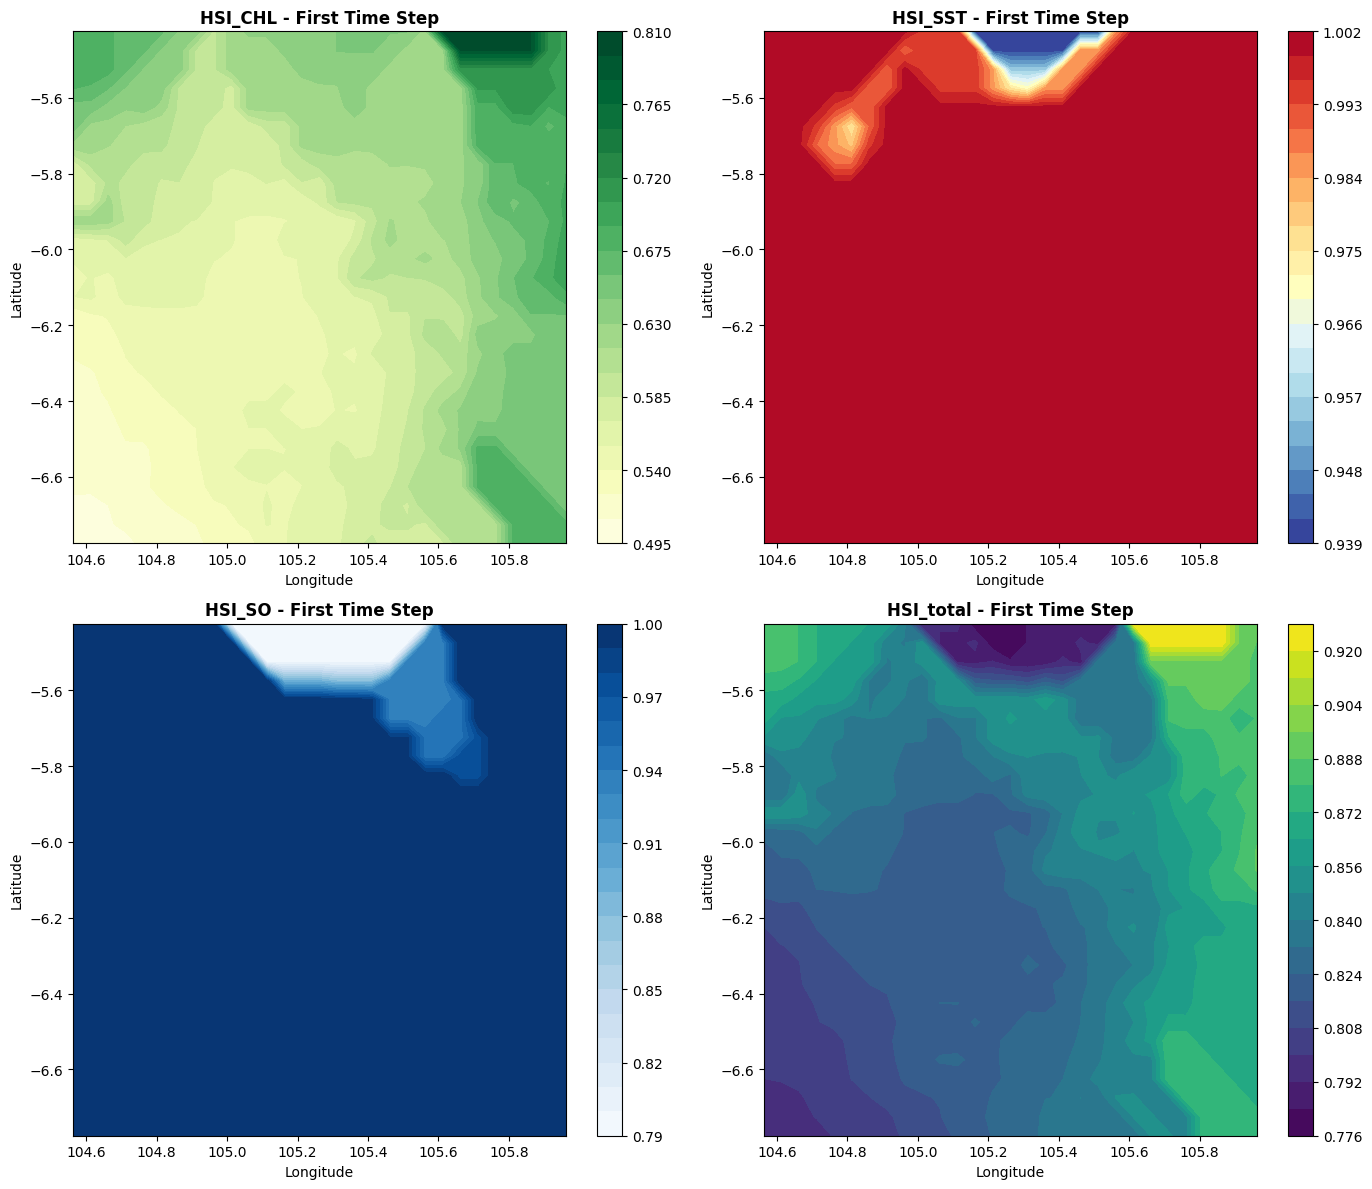

✅ Visualization saved to data/hsi_sample_visualization.png


In [12]:
# Check if HSI data exists
try:
    # Visualize first time step
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # HSI_CHL
    im1 = axes[0, 0].contourf(lon_grid, lat_grid, hsi_chl[0, :, :], levels=20, cmap='YlGn')
    axes[0, 0].set_title('HSI_CHL - First Time Step', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')
    plt.colorbar(im1, ax=axes[0, 0])

    # HSI_SST
    im2 = axes[0, 1].contourf(lon_grid, lat_grid, hsi_sst[0, :, :], levels=20, cmap='RdYlBu_r')
    axes[0, 1].set_title('HSI_SST - First Time Step', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Longitude')
    axes[0, 1].set_ylabel('Latitude')
    plt.colorbar(im2, ax=axes[0, 1])

    # HSI_SO
    im3 = axes[1, 0].contourf(lon_grid, lat_grid, hsi_so[0, :, :], levels=20, cmap='Blues')
    axes[1, 0].set_title('HSI_SO - First Time Step', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    plt.colorbar(im3, ax=axes[1, 0])

    # HSI_total
    im4 = axes[1, 1].contourf(lon_grid, lat_grid, hsi_total[0, :, :], levels=20, cmap='viridis')
    axes[1, 1].set_title('HSI_total - First Time Step', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    plt.colorbar(im4, ax=axes[1, 1])

    plt.tight_layout()
    
    # Create output directory if not exists
    os.makedirs('../data', exist_ok=True)
    
    plt.savefig('../data/hsi_sample_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Visualization saved to data/hsi_sample_visualization.png")
    
except NameError as e:
    print(f"⚠️  Error: {e}")
    print("Please run Cell 3 (Calculate HSI) first!")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()

## 5. Save HSI Results

In [13]:
# Save HSI data
OUTPUT_DIR = '../data/processed'
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    np.savez_compressed(
        f"{OUTPUT_DIR}/hsi_data.npz",
        hsi_total=hsi_total,
        hsi_chl=hsi_chl,
        hsi_sst=hsi_sst,
        hsi_so=hsi_so,
        chl=processed_chl,
        sst=processed_sst,
        salinity=processed_salinity,
        lat_grid=lat_grid,
        lon_grid=lon_grid
    )

    print(f"✅ HSI data saved to {OUTPUT_DIR}/hsi_data.npz")
    print(f"\nFile contains:")
    print(f"  - hsi_total: {hsi_total.shape}")
    print(f"  - hsi_chl: {hsi_chl.shape}")
    print(f"  - hsi_sst: {hsi_sst.shape}")
    print(f"  - hsi_so: {hsi_so.shape}")
    print(f"  - Original data (chl, sst, salinity)")
    print(f"  - Grid coordinates (lat_grid, lon_grid)")
    
except NameError as e:
    print(f"⚠️  Error: {e}")
    print("Please run Cell 3 (Calculate HSI) first!")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()

✅ HSI data saved to ../data/processed/hsi_data.npz

File contains:
  - hsi_total: (1461, 28, 29)
  - hsi_chl: (1461, 28, 29)
  - hsi_sst: (1461, 28, 29)
  - hsi_so: (1461, 28, 29)
  - Original data (chl, sst, salinity)
  - Grid coordinates (lat_grid, lon_grid)


## 6. Summary & Next Steps

In [14]:
print("=== HSI CALCULATION SUMMARY ===")
print("\n✅ HSI calculation completed successfully!")
print("\nWhat was done:")
print("1. ✅ Defined Suitability Index functions (HSI_CHL, HSI_SST, HSI_SO)")
print("2. ✅ Calculated HSI for each parameter")
print("3. ✅ Calculated HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)")
print("4. ✅ Handled edge cases (missing values, zero values)")
print("5. ✅ Saved results to file")
print("\nNext Steps:")
print("- Fase 4: Monthly Aggregation")
print("  - Agregasi data harian menjadi bulanan (mean)")
print("  - Generate 36 dataset bulanan (3 tahun × 12 bulan)")
print("\nOutput file: data/processed/hsi_data.npz")

=== HSI CALCULATION SUMMARY ===

✅ HSI calculation completed successfully!

What was done:
1. ✅ Defined Suitability Index functions (HSI_CHL, HSI_SST, HSI_SO)
2. ✅ Calculated HSI for each parameter
3. ✅ Calculated HSI_total = (HSI_CHL × HSI_SST × HSI_SO)^(1/3)
4. ✅ Handled edge cases (missing values, zero values)
5. ✅ Saved results to file

Next Steps:
- Fase 4: Monthly Aggregation
  - Agregasi data harian menjadi bulanan (mean)
  - Generate 36 dataset bulanan (3 tahun × 12 bulan)

Output file: data/processed/hsi_data.npz
